# 1.0 Imports

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import precision_recall_curve
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch

## 1.1 Funções de ajuda

In [2]:
# Caminho dos dados
dataPath = "../data/"

In [3]:
def set_feature_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    for col_name in df.columns:
        if col_name.endswith("A") or col_name.endswith("P"):
            df = df.with_columns(pl.col(col_name).cast(pl.Float64))
    return df

def optimize_pandas_conversion(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            if "Unknown" not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories("Unknown")
    return df

# 2.0 Carregamento dos dados

## 2.1 Treino

In [4]:
train_base_df = pl.read_csv(os.path.join(dataPath, "train/train_base.csv"))
train_static_df = pl.concat([
    pl.read_csv(os.path.join(dataPath, "train/train_static_0_0.csv")).pipe(set_feature_dtypes),
    pl.read_csv(os.path.join(dataPath, "train/train_static_0_1.csv")).pipe(set_feature_dtypes),
], how="vertical_relaxed")
train_static_cb_df = pl.read_csv(os.path.join(dataPath, "train/train_static_cb_0.csv")).pipe(set_feature_dtypes)
train_person_1_df = pl.read_csv(os.path.join(dataPath, "train/train_person_1.csv")).pipe(set_feature_dtypes)
train_credit_bureau_b_2_df = pl.read_csv(os.path.join(dataPath, "train/train_credit_bureau_b_2.csv")).pipe(set_feature_dtypes)
train_applprev_1_df = pl.concat([
    pl.read_csv(os.path.join(dataPath, "train/train_applprev_1_0.csv")).pipe(set_feature_dtypes),
    pl.read_csv(os.path.join(dataPath, "train/train_applprev_1_1.csv")).pipe(set_feature_dtypes),
], how="vertical_relaxed")

## 2.2 Teste

In [5]:
test_base_df = pl.read_csv(os.path.join(dataPath, "test/test_base.csv"))
test_static_df = pl.concat([
    pl.read_csv(os.path.join(dataPath, "test/test_static_0_0.csv")).pipe(set_feature_dtypes),
    pl.read_csv(os.path.join(dataPath, "test/test_static_0_1.csv")).pipe(set_feature_dtypes),
    pl.read_csv(os.path.join(dataPath, "test/test_static_0_2.csv")).pipe(set_feature_dtypes),
], how="vertical_relaxed")
test_static_cb_df = pl.read_csv(os.path.join(dataPath, "test/test_static_cb_0.csv")).pipe(set_feature_dtypes)
test_person_1_df = pl.read_csv(os.path.join(dataPath, "test/test_person_1.csv")).pipe(set_feature_dtypes)
test_credit_bureau_b_2_df = pl.read_csv(os.path.join(dataPath, "test/test_credit_bureau_b_2.csv")).pipe(set_feature_dtypes)
test_applprev_1_df = pl.concat([
    pl.read_csv(os.path.join(dataPath, "test/test_applprev_1_0.csv")).pipe(set_feature_dtypes),
    pl.read_csv(os.path.join(dataPath, "test/test_applprev_1_1.csv")).pipe(set_feature_dtypes),
], how="vertical_relaxed")

# 3.0 Engenharia de Features

In [6]:
# Agregações para person_1
agg_person_1 = train_person_1_df.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("feat_person_income_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("feat_person_is_selfemployed")
)
agg_person_1_main = train_person_1_df.filter(pl.col("num_group1") == 0).select(
    "case_id", pl.col("housetype_905L").alias("feat_person_housetype")
)

# Agregações para credit_bureau_b_2
agg_credit_bureau_b_2 = train_credit_bureau_b_2_df.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("feat_bureau_overdue_max"),
    (pl.col("pmts_dpdvalue_108P") > 30).max().alias("feat_bureau_dpd_over30_flag")
)

# Agregações para applprev_1 
agg_applprev_1 = train_applprev_1_df.group_by("case_id").agg(
    pl.col("credamount_590A").mean().alias("feat_applprev_credamount_mean"),
    (pl.col("status_219L") == "REFUSED").sum().alias("feat_applprev_refused_count")
)

# Repetindo para os dados de teste
test_agg_person_1 = test_person_1_df.group_by("case_id").agg(pl.col("mainoccupationinc_384A").max().alias("feat_person_income_max"),(pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("feat_person_is_selfemployed"))
test_agg_person_1_main = test_person_1_df.filter(pl.col("num_group1") == 0).select("case_id", pl.col("housetype_905L").alias("feat_person_housetype"))
test_agg_credit_bureau_b_2 = test_credit_bureau_b_2_df.group_by("case_id").agg(pl.col("pmts_pmtsoverdue_635A").max().alias("feat_bureau_overdue_max"),(pl.col("pmts_dpdvalue_108P") > 30).max().alias("feat_bureau_dpd_over30_flag"))
test_agg_applprev_1 = test_applprev_1_df.group_by("case_id").agg(pl.col("credamount_590A").mean().alias("feat_applprev_credamount_mean"),(pl.col("status_219L") == "REFUSED").sum().alias("feat_applprev_refused_count"))

# 4.0 Junção das tabelas

In [7]:
static_cols_to_keep = ['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A',
                       'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A',
                       'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A',
                       'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A',
                       'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A',
                       'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallast1m_4525188A']
static_cb_cols_to_keep = ['description_5085714M', 'education_1103M', 'education_88M', 'maritalst_385M', 'maritalst_893M', 'pmtaverage_3A', 'pmtaverage_4527227A', 'pmtaverage_4955615A', 'pmtssum_45A']

# Processando o conjunto de TREINO
df_train_processed = train_base_df.join(
    train_static_df.select(["case_id"] + static_cols_to_keep), how="left", on="case_id"
).join(
    train_static_cb_df.select(["case_id"] + static_cb_cols_to_keep), how="left", on="case_id"
).join(
    agg_person_1, how="left", on="case_id"
).join(
    agg_person_1_main, how="left", on="case_id"
).join(
    agg_credit_bureau_b_2, how="left", on="case_id"
).join(
    agg_applprev_1, how="left", on="case_id"
)

# Processando o conjunto de TESTE
df_test_processed = test_base_df.join(
    test_static_df.select(["case_id"] + static_cols_to_keep), how="left", on="case_id"
).join(
    test_static_cb_df.select(["case_id"] + static_cb_cols_to_keep), how="left", on="case_id"
).join(
    test_agg_person_1, how="left", on="case_id"
).join(
    test_agg_person_1_main, how="left", on="case_id"
).join(
    test_agg_credit_bureau_b_2, how="left", on="case_id"
).join(
    test_agg_applprev_1, how="left", on="case_id"
)

# 5.0 Conversão final

In [ ]:
# Embaralhando os case_ids
all_case_ids = df_train_processed.select("case_id").unique().sample(fraction=1.0, shuffle=True, seed=1).to_series()

# Separando os IDs
train_ids, test_ids_temp = train_test_split(all_case_ids, train_size=0.6, random_state=1)
valid_ids, test_ids = train_test_split(test_ids_temp, train_size=0.5, random_state=1)

# Seleção de features
metadata_cols = ["case_id", "WEEK_NUM", "target", "date_decision", "MONTH"]
final_feature_cols = [col for col in df_train_processed.columns if col not in metadata_cols]

# Função para preparar e converter os datasets
def finalize_dataset(df: pl.DataFrame, ids: pl.DataFrame, feature_cols: list) -> tuple:
    
    # Filtra o dataframe pelos IDs do conjunto (treino, validação ou teste)
    ids_df = ids.to_frame("case_id") 
    df_filtered = df.join(ids_df, on="case_id", how="semi")
    
    # Converte colunas de texto para Categoria dentro do Polars
    df_optimized = df_filtered.with_columns(
        pl.col(pl.Utf8).cast(pl.Categorical)
    )
    
    base = df_optimized.select(["case_id", "WEEK_NUM", "target"]).to_pandas()
    
    # Seleciona as colunas de features e o alvo
    X = df_optimized.select(feature_cols).to_pandas()
    y = df_optimized.select("target").to_pandas().iloc[:, 0]
    
    return base, X, y

# Selecionando features
metadata_cols = ["case_id", "WEEK_NUM", "target", "date_decision", "MONTH"]
final_feature_cols = [col for col in df_train_processed.columns if col not in metadata_cols]

base_train, X_train, y_train = finalize_dataset(df_train_processed, train_ids, final_feature_cols)
base_valid, X_valid, y_valid = finalize_dataset(df_train_processed, valid_ids, final_feature_cols)
base_test, X_test, y_test = finalize_dataset(df_train_processed, test_ids, final_feature_cols)

print(f"Número de features finais: {len(final_feature_cols)}")
print(f"Formato de Saída (Train): {X_train.shape}, {y_train.shape}")
print(f"Formato de Saída (Valid): {X_valid.shape}, {y_valid.shape}")
print(f"Formato de Saída (Test):  {X_test.shape}, {y_test.shape}")

Número de features finais: 55
Formato de Saída (Train): (915995, 55), (915995,)
Formato de Saída (Valid): (305332, 55), (305332,)
Formato de Saída (Test):  (305332, 55), (305332,)


# 6.0 EDA

## 6.1 Análise do Target

Distribuição da variável alvo (y_train):
target
0    0.96872
1    0.03128
Name: proportion, dtype: float64


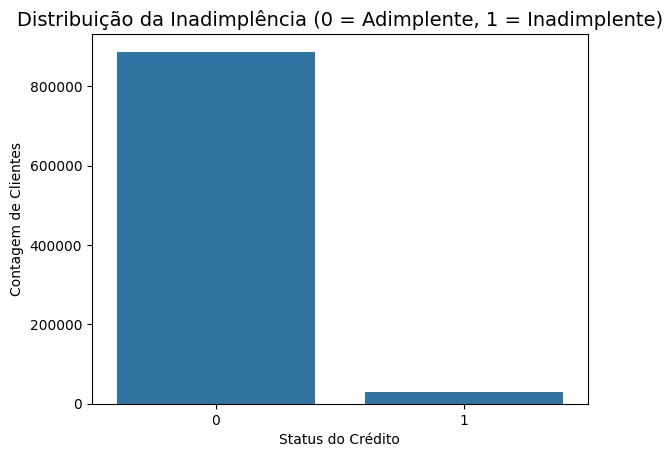

In [9]:
print("Distribuição da variável alvo (y_train):")
print(y_train.value_counts(normalize=True))

# Gráfico de contagem
ax = sns.countplot(x=y_train)
ax.set_title("Distribuição da Inadimplência (0 = Adimplente, 1 = Inadimplente)", fontsize=14)
ax.set_xlabel("Status do Crédito")
ax.set_ylabel("Contagem de Clientes")
plt.show()

## 6.2 Check de valores nulos

In [10]:
missing_info = pd.DataFrame({
    'count': X_train.isnull().sum(),
    'percentage': np.round((X_train.isnull().sum() / len(X_train)) * 100, 2)
}).sort_values(by='percentage', ascending=False)

print("Top 20 features com mais valores ausentes em X_train:")
print(missing_info.head(20))

Top 20 features com mais valores ausentes em X_train:
                                  count  percentage
lastotherlnsexpense_631A         914172       99.80
lastotherinc_902A                914167       99.80
feat_bureau_dpd_over30_flag      894018       97.60
feat_bureau_overdue_max          894018       97.60
pmtaverage_4955615A              872953       95.30
maxannuity_4075009A              870126       94.99
feat_person_housetype            855556       93.40
pmtaverage_4527227A              847097       92.48
pmtaverage_3A                    829775       90.59
avglnamtstart24m_4525187A        818404       89.35
inittransactionamount_650A       800524       87.39
totinstallast1m_4525188A         704365       76.90
maxpmtlast3m_4525190A            677564       73.97
maxlnamtstart6m_4525199A         619609       67.64
avgpmtlast12m_4525200A           616079       67.26
pmtssum_45A                      572846       62.54
avgoutstandbalancel6m_4187114A   504561       55.08
sumoutstan

## 6.3 Features numéricas

### 6.3.1 Analisando Renda Máxima

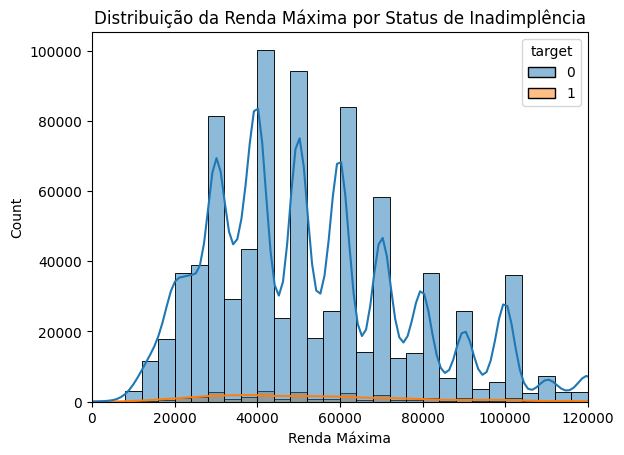

In [11]:
df_eda_train = base_train.join(X_train)

sns.histplot(data=df_eda_train, x='feat_person_income_max', hue='target', bins=50, kde=True)
plt.title("Distribuição da Renda Máxima por Status de Inadimplência")
plt.xlabel("Renda Máxima")

plt.xlim(0, df_eda_train['feat_person_income_max'].quantile(0.95))
plt.show()

### 6.3.2 Análise de Correlação com o Alvo

In [12]:
print("\nTop 10 features mais correlacionadas com a inadimplência (target):")
correlations = df_eda_train.corr(numeric_only=True)['target'].sort_values(ascending=False)
print(correlations.head(11))

print("\nTop 10 features com maior correlação negativa com a inadimplência:")
print(correlations.tail(10))


Top 10 features mais correlacionadas com a inadimplência (target):
target                           1.000000
avglnamtstart24m_4525187A        0.031050
price_1097A                      0.028709
disbursedcredamount_1113A        0.028001
credamount_770A                  0.026685
sumoutstandtotalest_4493215A     0.026154
sumoutstandtotal_3546847A        0.021269
totaldebt_9A                     0.021173
currdebt_22A                     0.021152
feat_applprev_credamount_mean    0.018808
feat_bureau_overdue_max          0.018409
Name: target, dtype: float64

Top 10 features com maior correlação negativa com a inadimplência:
maininc_215A                     -0.010896
maxannuity_4075009A              -0.014323
totalsettled_863A                -0.018998
maxdebt4_972A                    -0.025662
pmtaverage_4955615A              -0.042881
pmtssum_45A                      -0.044147
amtinstpaidbefduel24m_4187115A   -0.045459
pmtaverage_3A                    -0.055852
pmtaverage_4527227A          

## 6.4 Análise Categórica

### 6.4.1 Inadimplência

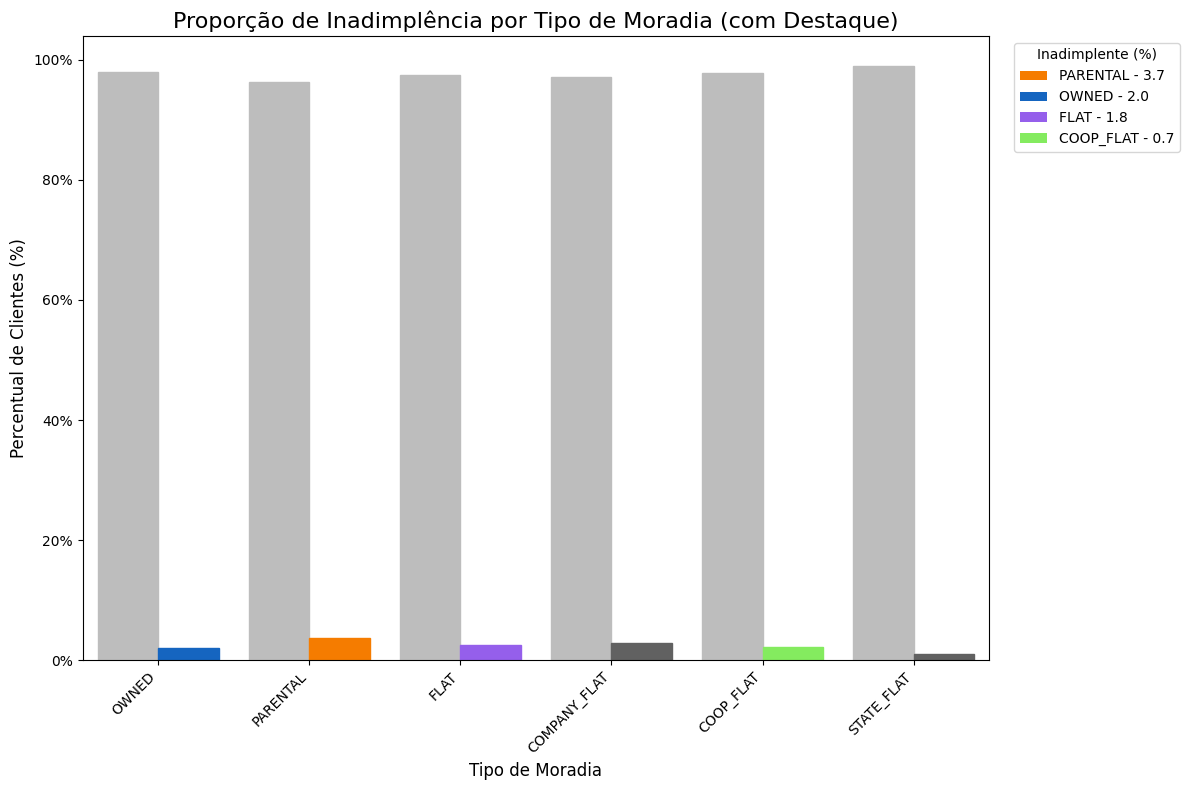

In [13]:
# Calculando proporcões
df_proportions = df_eda_train.groupby('feat_person_housetype', observed=False)['target'].value_counts(normalize=True).mul(100).rename('proportion').reset_index()

# Ordem das categorias para o gráfico
order = df_eda_train['feat_person_housetype'].value_counts().index

# Mapa de cores
color_map = {
    'OWNED':    {0: '#bdbdbd', 1: '#1565c0'},  
    'PARENTAL': {0: '#bdbdbd', 1: '#f57c00'},
    'DEFAULT':  {0: '#bdbdbd', 1: '#616161'},
    'FLAT':     {0: '#bdbdbd', 1: '#955feb'},
    'COOP_FLAT':{0: '#bdbdbd', 1: "#84eb5f"}
}

# Plotando o gráfico
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=df_proportions,
    x='feat_person_housetype',
    y='proportion',
    hue='target',
    order=order,
    legend=False
)

hue_order = df_proportions['target'].unique() 

for i, container in enumerate(ax.containers):
    current_hue_value = hue_order[i]
    
    for j, bar in enumerate(container):
        current_x_label = order[j]
        if current_x_label in ['OWNED', 'PARENTAL', 'FLAT', 'COOP_FLAT']:
            bar.set_color(color_map[current_x_label][current_hue_value])
        else:
            bar.set_color(color_map['DEFAULT'][current_hue_value])

# Legenda personalizada
legend_elements = [
    Patch(facecolor=color_map['PARENTAL'][1], label='PARENTAL - 3.7'),
    Patch(facecolor=color_map['OWNED'][1], label='OWNED - 2.0'),
    Patch(facecolor=color_map['FLAT'][1], label='FLAT - 1.8'),
    Patch(facecolor=color_map['COOP_FLAT'][1], label='COOP_FLAT - 0.7'),
]
ax.legend(handles=legend_elements, title='Inadimplente (%)', bbox_to_anchor=(1.02, 1), loc='upper left')

ax.set_title("Proporção de Inadimplência por Tipo de Moradia (com Destaque)", fontsize=16)
ax.set_xlabel("Tipo de Moradia", fontsize=12)
ax.set_ylabel("Percentual de Clientes (%)", fontsize=12)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

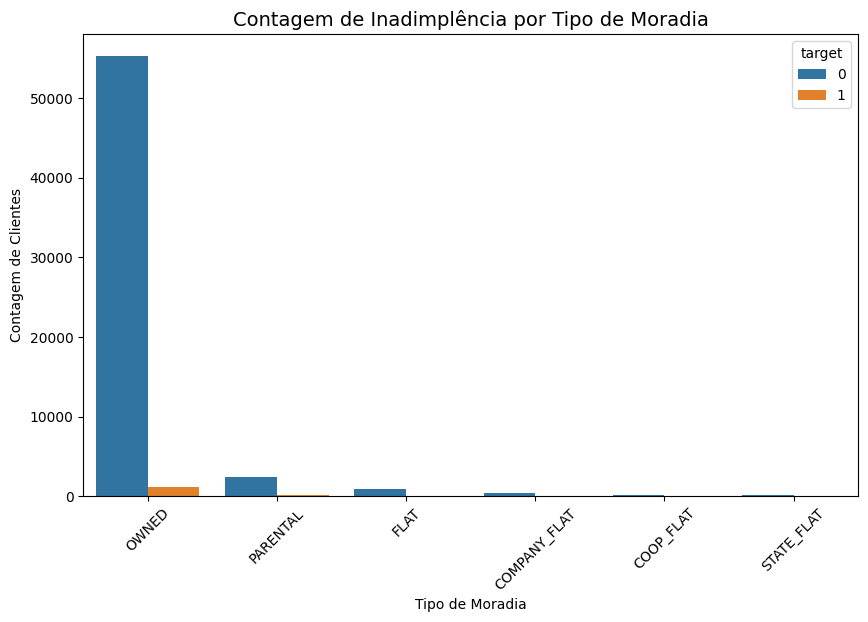


Taxa de inadimplência por tipo de moradia:
feat_person_housetype
PARENTAL        0.037461
COMPANY_FLAT    0.028490
FLAT            0.024554
COOP_FLAT       0.022222
OWNED           0.020668
STATE_FLAT      0.009615
Name: target, dtype: float64


In [14]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_eda_train, x='feat_person_housetype', hue='target', order = df_eda_train['feat_person_housetype'].value_counts().index)
ax.set_title("Contagem de Inadimplência por Tipo de Moradia", fontsize=14)
ax.set_xlabel("Tipo de Moradia")
ax.set_ylabel("Contagem de Clientes")
plt.xticks(rotation=45)
plt.show()

# Calculando a taxa de inadimplência por categoria
default_rate_by_housetype = df_eda_train.groupby('feat_person_housetype', observed=False)['target'].mean().sort_values(ascending=False)
print("\nTaxa de inadimplência por tipo de moradia:")
print(default_rate_by_housetype)

### 6.4.2 Análise Temporal

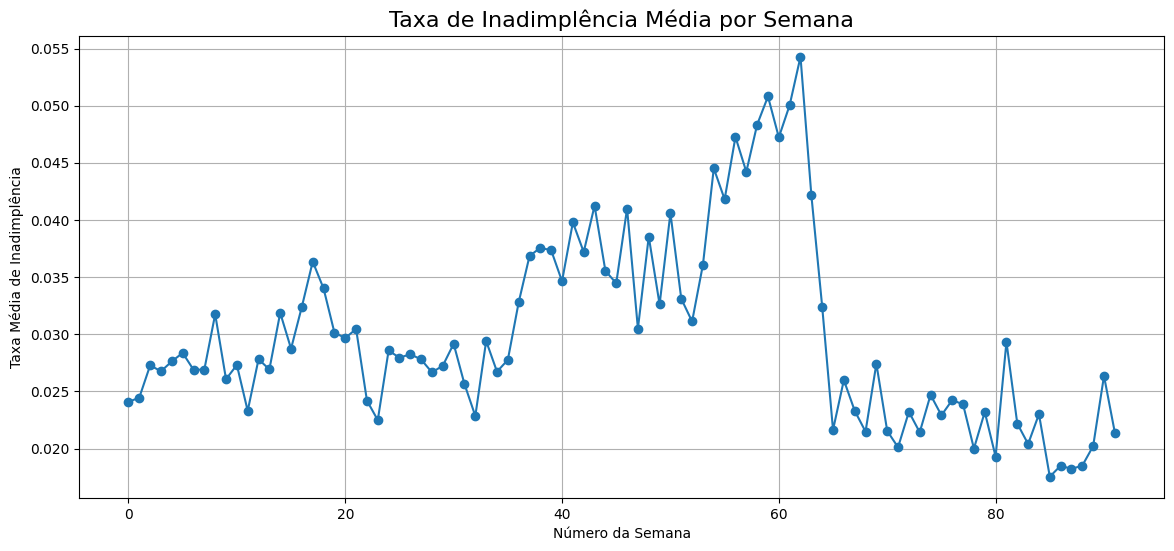

In [15]:
# Agrupando por semana e calculando a taxa de inadimplência
taxa_inadimplencia_semanal = df_eda_train.groupby('WEEK_NUM')['target'].mean()

# Plotando o resultado
plt.figure(figsize=(14, 6))
taxa_inadimplencia_semanal.plot(kind='line', marker='o', linestyle='-')
plt.title('Taxa de Inadimplência Média por Semana', fontsize=16)
plt.xlabel('Número da Semana')
plt.ylabel('Taxa Média de Inadimplência')
plt.grid(True)
plt.show()

### 6.4.3 Análise de Endividamento

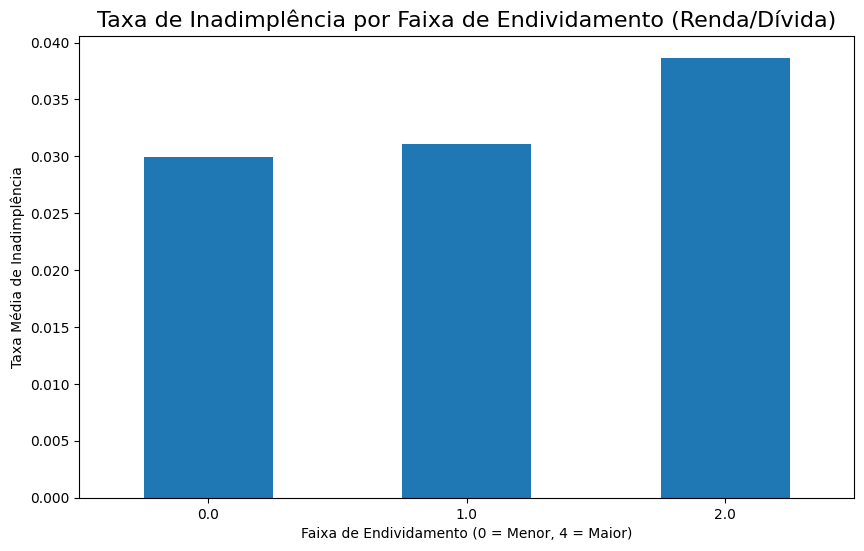

In [16]:
# Usando as colunas 'currdebt_22A' (dívida atual) e 'maininc_215A' (renda principal)
df_eda_train['debt_to_income_ratio'] = df_eda_train['currdebt_22A'] / (df_eda_train['maininc_215A'] + 1e-6)

# Criando 5 faixas (quantis) para essa nova feature
df_eda_train['debt_to_income_bin'] = pd.qcut(df_eda_train['debt_to_income_ratio'], q=5, labels=False, duplicates='drop')

# Calculando a taxa de inadimplência por faixa de endividamento
taxa_inadimplencia_por_divida = df_eda_train.groupby('debt_to_income_bin')['target'].mean()

# Plotando o resultado
plt.figure(figsize=(10, 6))
taxa_inadimplencia_por_divida.plot(kind='bar')
plt.title('Taxa de Inadimplência por Faixa de Endividamento (Renda/Dívida)', fontsize=16)
plt.xlabel('Faixa de Endividamento (0 = Menor, 4 = Maior)')
plt.ylabel('Taxa Média de Inadimplência')
plt.xticks(rotation=0)
plt.show()

# 7.0 Preparação dos dados

## 7.1 Removendo colunas com > 90% de valores nulos

In [17]:
cols_to_drop = [
    'lastotherlnsexpense_631A', 
    'lastotherinc_902A', 
    'feat_bureau_dpd_over30_flag', 
    'feat_bureau_overdue_max'
]

# Garantir que as colunas existem antes de tentar remover
cols_to_drop_existing = [col for col in cols_to_drop if col in X_train.columns]

X_train_cleaned = X_train.drop(columns=cols_to_drop_existing)
X_valid_cleaned = X_valid.drop(columns=cols_to_drop_existing)
X_test_cleaned = X_test.drop(columns=cols_to_drop_existing)

print(f"Shape de X_train após limpeza: {X_train_cleaned.shape}")

Shape de X_train após limpeza: (915995, 51)


## 7.2 Construção do Pipeline de Pré-processamento

In [18]:
# Separando as colunas por tipo
numeric_features = X_train_cleaned.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train_cleaned.select_dtypes(include='category').columns.tolist()

# Criando o pipeline para features numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Criando o pipeline para features categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinando os dois pipelines com ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## 7.3 Treinamento do Modelo LightGBM

In [19]:
# Criando o pipeline final que inclui o pré-processamento e o classificador
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=42))
])

# Treinando o modelo
model_pipeline.fit(X_train_cleaned, y_train)

[LightGBM] [Info] Number of positive: 28652, number of negative: 887343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9896
[LightGBM] [Info] Number of data points in the train set: 915995, number of used features: 532
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031280 -> initscore=-3.433008
[LightGBM] [Info] Start training from score -3.433008


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 7.4 Avaliação do Modelo

In [20]:
# Alinhando a ordem das colunas
train_column_order = X_train_cleaned.columns.tolist()
X_valid_ordered = X_valid_cleaned[train_column_order]

# Fazendo previsões de probabilidade com o dataframe ordenado
y_pred_proba = model_pipeline.predict_proba(X_valid_ordered)[:, 1]

# Calculando a métrica AUC-ROC
auc = roc_auc_score(y_valid, y_pred_proba)
print(f"AUC-ROC na Validação: {auc:.4f}")

# Fazendo previsões de classe com o dataframe ordenado
y_pred_class = model_pipeline.predict(X_valid_ordered)
print("\nRelatório de Classificação na Validação:")
print(classification_report(y_valid, y_pred_class))

/Users/raphael/.pyenv/versions/3.11.5/envs/powerofdata/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC-ROC na Validação: 0.7490


/Users/raphael/.pyenv/versions/3.11.5/envs/powerofdata/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Relatório de Classificação na Validação:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    295690
           1       0.36      0.00      0.00      9642

    accuracy                           0.97    305332
   macro avg       0.66      0.50      0.49    305332
weighted avg       0.95      0.97      0.95    305332



# 8.0 Otimização

## 8.1 Conferindo peso das classes

In [21]:
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count

print(f"Número de Adimplentes (classe 0): {neg_count}")
print(f"Número de Inadimplentes (classe 1): {pos_count}")
print(f"Valor calculado para scale_pos_weight: {scale_pos_weight_value:.2f}")

Número de Adimplentes (classe 0): 887343
Número de Inadimplentes (classe 1): 28652
Valor calculado para scale_pos_weight: 30.97


## 8.2 Treinando o modelo otimizado

In [22]:
optimized_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight_value,
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31
    ))
])

# Treinando o novo modelo
optimized_model_pipeline.fit(X_train_cleaned, y_train)

[LightGBM] [Info] Number of positive: 28652, number of negative: 887343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9896
[LightGBM] [Info] Number of data points in the train set: 915995, number of used features: 532
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031280 -> initscore=-3.433008
[LightGBM] [Info] Start training from score -3.433008


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 8.3 Avaliação

In [23]:
# Fazendo previsões de probabilidade
y_pred_proba_opt = optimized_model_pipeline.predict_proba(X_valid_cleaned)[:, 1]

# Calculando a métrica AUC-ROC
auc_opt = roc_auc_score(y_valid, y_pred_proba_opt)
print(f"AUC-ROC na Validação (Otimizado): {auc_opt:.4f}")

# Exibindo o relatório de classificação
y_pred_class_opt = optimized_model_pipeline.predict(X_valid_cleaned)
print("\nRelatório de Classificação na Validação (Otimizado):")
print(classification_report(y_valid, y_pred_class_opt))

/Users/raphael/.pyenv/versions/3.11.5/envs/powerofdata/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC-ROC na Validação (Otimizado): 0.7524


/Users/raphael/.pyenv/versions/3.11.5/envs/powerofdata/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Relatório de Classificação na Validação (Otimizado):
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    295690
           1       0.07      0.68      0.12      9642

    accuracy                           0.69    305332
   macro avg       0.53      0.68      0.47    305332
weighted avg       0.96      0.69      0.79    305332



## 8.4 Analisando Curva Precision-Recall

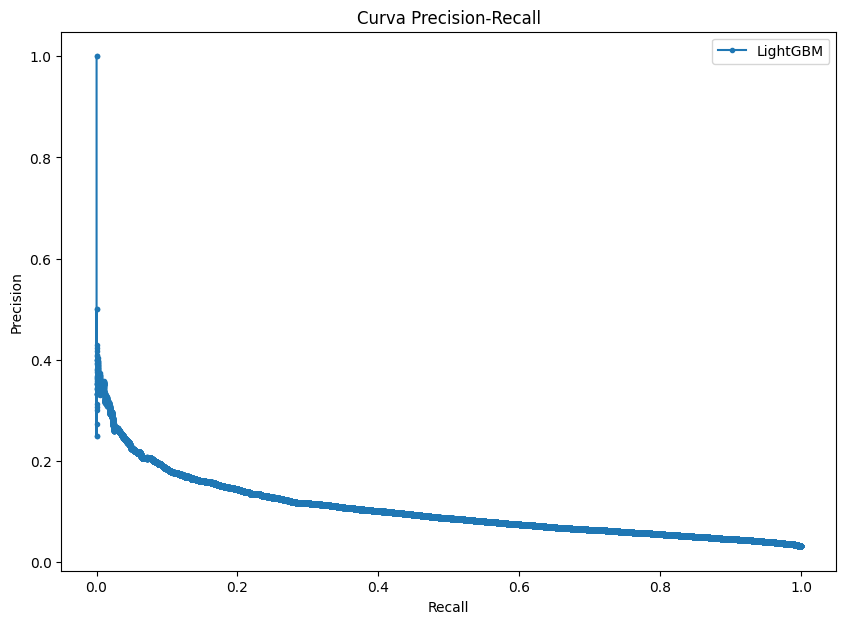

Melhor Limiar (Threshold) encontrado: 0.7217
F1-Score nesse ponto: 0.1699
Precision nesse ponto: 0.1334
Recall nesse ponto: 0.2337


In [24]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba_opt)

# Plotando a Curva
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.', label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

# Encontrando o melhor limiar com base no F1-Score
# Adicionei um pequeno valor (epsilon) para evitar divisão por zero
epsilon = 1e-7
f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)

# Localizar o índice do maior F1-Score
ix = np.argmax(f1_scores)
best_threshold = thresholds[ix]

print(f"Melhor Limiar (Threshold) encontrado: {best_threshold:.4f}")
print(f"F1-Score nesse ponto: {f1_scores[ix]:.4f}")
print(f"Precision nesse ponto: {precision[ix]:.4f}")
print(f"Recall nesse ponto: {recall[ix]:.4f}")

## 8.5 Avaliação final

In [25]:
print("Relatório de Classificação (Threshold Padrão = 0.5)")
print("Resultado anterior:")
print(classification_report(y_valid, y_pred_class_opt))

print("\nRelatório de Classificação (Threshold Otimizado)")
print(f"Este é o resultado usando o novo limiar de {best_threshold:.2f}:")

# Aplicando o novo limiar para obter as novas classes
y_pred_new_threshold = (y_pred_proba_opt >= best_threshold).astype(int)

print(classification_report(y_valid, y_pred_new_threshold))

Relatório de Classificação (Threshold Padrão = 0.5)
Resultado anterior:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    295690
           1       0.07      0.68      0.12      9642

    accuracy                           0.69    305332
   macro avg       0.53      0.68      0.47    305332
weighted avg       0.96      0.69      0.79    305332


Relatório de Classificação (Threshold Otimizado)
Este é o resultado usando o novo limiar de 0.72:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96    295690
           1       0.13      0.23      0.17      9642

    accuracy                           0.93    305332
   macro avg       0.55      0.59      0.57    305332
weighted avg       0.95      0.93      0.94    305332

